# Descarga de dataset

In [1]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"enriqueguz1701","key":"7849cc978b31b3d3352bf37ecaffd791"}'}

In [2]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!(kaggle datasets list -s sprites)

ref                                                              title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ebrahimelgazar/pixel-art                                         Pixel Art                                          86MB  2024-02-10 12:17:36           1269         30  1.0              
thecaptian/pokemon-sprites                                       Pokemon Sprites                                   288MB  2022-05-23 12:48:12             66          2  0.6875           
csalexi/animal-crossing-sprites                                  Animal Crossing Villager Sprites                  514MB  2022-02-11 04:08:17             25          8  0.5              
bhavyadhingra00020/complete-pokemon-dataset-9th-gen-img-tabular  

In [4]:
!kaggle datasets download -d ebrahimelgazar/pixel-art

Dataset URL: https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art
License(s): apache-2.0
 93% 80.0M/85.7M [00:01<00:00, 86.6MB/s]
100% 85.7M/85.7M [00:01<00:00, 71.6MB/s]


In [5]:
# Creemos un directorio para descomprimir los datos
!mkdir sprites

In [6]:
# Descomprimimos los datos y los dejamos listos para trabajar
%%capture
!unzip pixel-art.zip -d sprites

In [7]:
!ls sprites

images	labels.csv  sprites_labels.npy	sprites.npy


# Imports

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import os
import random
import keras
import tensorflow as tf
from keras import layers
from keras import ops

from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

# from vae import VAE
# from my_data_generator import DataGenerator
# from gan import GAN, GANMonitor
from gan_v2 import GAN_ADA

In [23]:
# Cargar las imágenes desde sprites.npy
images = np.load('sprites/sprites.npy')

# Crear carpeta de destino si no existe
output_folder = 'sprites/sprites_png'
os.makedirs(output_folder, exist_ok=True)

# Guardar cada imagen
for i, img_array in enumerate(images):
    # Verifica si img_array tiene rango [-1, 1] o [0, 1] y normaliza a [0, 255]
    if img_array.min() < 0:  # Caso normalizado [-1, 1]
        img_array = ((img_array + 1) * 127.5).astype('uint8')
    elif img_array.max() <= 1:  # Caso normalizado [0, 1]
        img_array = (img_array * 255).astype('uint8')
    else:  # Si ya está en [0, 255]
        img_array = img_array.astype('uint8')

    # Convierte de RGB a BGR antes de guardar con OpenCV
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

    # Guardar la imagen
    output_path = os.path.join(output_folder, f'image_{i}.png')
    cv2.imwrite(output_path, img_bgr)

print(f'Todas las imágenes se guardaron en la carpeta: {output_folder}')


Todas las imágenes se guardaron en la carpeta: sprites/sprites_png


In [24]:
def load_images(path, width, height):
    images = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.JPEG')):
                path_image = os.path.join(root, file)
                images.append(path_image)

    df = pd.DataFrame(images, columns=['File'])

    images = []
    labels = []

    for path in df['File']:
        image = cv2.imread(path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (width, height))
            image = image/255.0
            # imagen = np.expand_dims(imagen, axis=-1)
            images.append(image)
            labels.append(image)
        else:
            print(f"La imagen en {path} no se pudo cargar.")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [25]:
images, _ = load_images('sprites/sprites_png/', 16, 16)

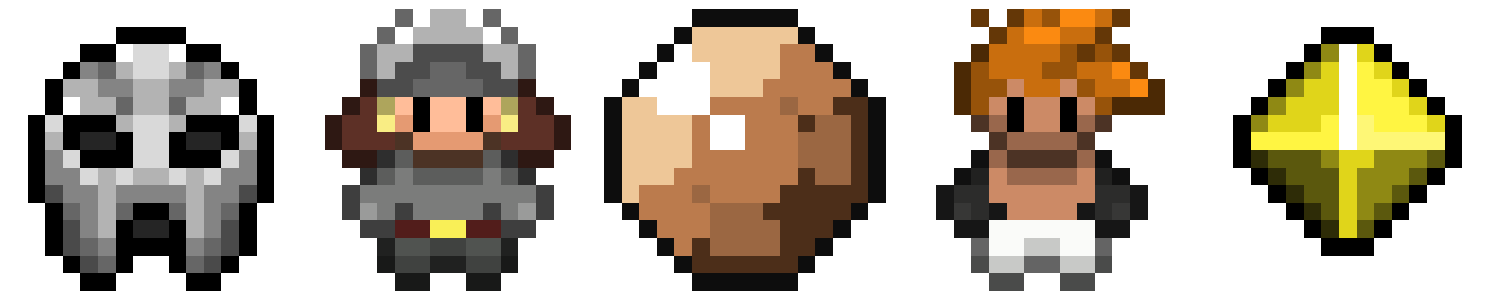

In [26]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for clase, ax in enumerate(axes):
    # Selecciona un índice aleatorio para la clase
    # indice_aleatorio = random.choice(indices_por_clase[clase])
    imagen_para_mostrar = (images[clase])  # Reescala para mostrar
    ax.imshow(imagen_para_mostrar)
    ax.axis('off')
    # ax.set_title(f"Clase: {clase}")  # Muestra el número de la clase como título

# Ajusta el layout y muestra las imágenes
plt.tight_layout()
plt.show()

# Sprites

In [13]:
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)


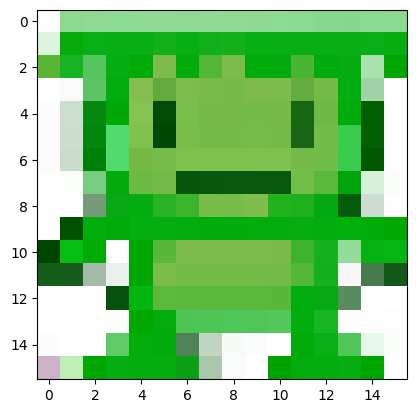

In [14]:
# Selecciona un índice aleatorio de X_test
indice_aleatorio = np.random.randint(0, X_test.shape[0])

# Para comprobar que se han cargado bien se mostrará una imagen al azar
index = random.randint(1, len(images))
plt.imshow(X_test[indice_aleatorio])
plt.show()

In [15]:
# data
num_epochs = 500  # train for 400 epochs for good results
image_size = 16
# resolution of Kernel Inception Distance measurement, see related section
kid_image_size = 75
padding = 0.25
dataset_name = "caltech_birds2011"

# adaptive discriminator augmentation
max_translation = 0.125
max_rotation = 0.125
max_zoom = 0.25
target_accuracy = 0.85
integration_steps = 1000

# architecture
noise_size = 64
depth = 4
width = 128
leaky_relu_slope = 0.2
dropout_rate = 0.4

# optimization
batch_size = 128
learning_rate = 2e-4
beta_1 = 0.5  # not using the default value of 0.9 is important
ema = 0.99

In [16]:
# DCGAN discriminator
def get_discriminator():
    image_input = keras.Input(shape=(image_size, image_size, 3))
    x = image_input
    for _ in range(2):
        x = layers.Conv2D(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.LeakyReLU(alpha=leaky_relu_slope)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_score = layers.Dense(1)(x)

    return keras.Model(image_input, output_score, name="discriminator")

In [17]:
def get_generator():
    noise_input = keras.Input(shape=(noise_size,))

    # Primero, se crea un tensor denso de tamaño (4, 4, width)
    x = layers.Dense(4 * 4 * width, use_bias=False)(noise_input)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)
    x = layers.Reshape(target_shape=(4, 4, width))(x)

    # Ahora, aumentamos la resolución utilizando capas Conv2DTranspose
    for _ in range(depth - 2):  # Depth debe ser 3 o más para tener 3 pasos de upsampling
        x = layers.Conv2DTranspose(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.ReLU()(x)

    # La última capa debe tener strides=2 para que pase de (8, 8) a (16, 16)
    image_output = layers.Conv2DTranspose(
        3, kernel_size=4, strides=1, padding="same", activation="sigmoid",
    )(x)

    return keras.Model(noise_input, image_output, name="generator")

# GAN V1

In [18]:
# create and compile the model
model = GAN_ADA(get_generator, get_discriminator, image_size, kid_image_size, batch_size, noise_size, ema)
model.build(input_shape=(batch_size, image_size, image_size, 3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         262,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 128)           │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 128)         │         262,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 3)           │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 668,419 (2.55 MB)

 Trainable params: 663,811 (2.53 MB)

 Non-trainable params: 4,608 (18.00 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 16, 16, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 8, 8, 128)           │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 128)           │         262,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 4, 128)           │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,105 (1.03 MB)

 Trainable params: 270,593 (1.03 MB)

 Non-trainable params: 512 (2.00 KB)

In [19]:
model.compile(
    generator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
    discriminator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
)

# save the best model based on the validation KID metric
checkpoint_path = "gan_model/gan.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="g_loss",
    mode="min",
    save_best_only=True,
)


In [20]:

# Crea un tf.data.Dataset a partir de X_train
train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)  # Descarta la última iteración si es incompleta

# Callback personalizado para ajustar el tamaño del batch en la última iteración
class AdjustBatchSizeCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        super(AdjustBatchSizeCallback, self).__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        # Obtiene el número total de ejemplos en el conjunto de datos
        num_examples = tf.data.experimental.cardinality(self.dataset).numpy()

        # Calcula el tamaño del último batch
        remaining_examples = num_examples % batch_size
        if remaining_examples != 0:
            # Ajusta el tamaño del batch para la última iteración
            self.model.batch_size = remaining_examples

In [21]:
# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=X_test,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

Output hidden; open in https://colab.research.google.com to view.

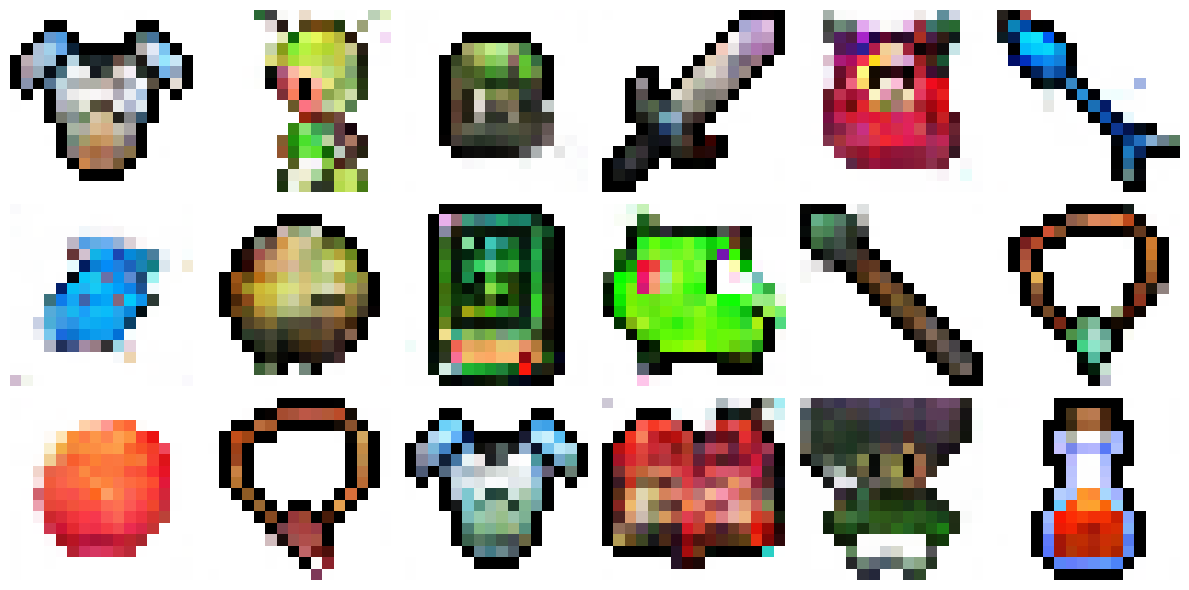

In [31]:
# load the best model and generate images
# model.load_weights(checkpoint_path)
model.plot_images()

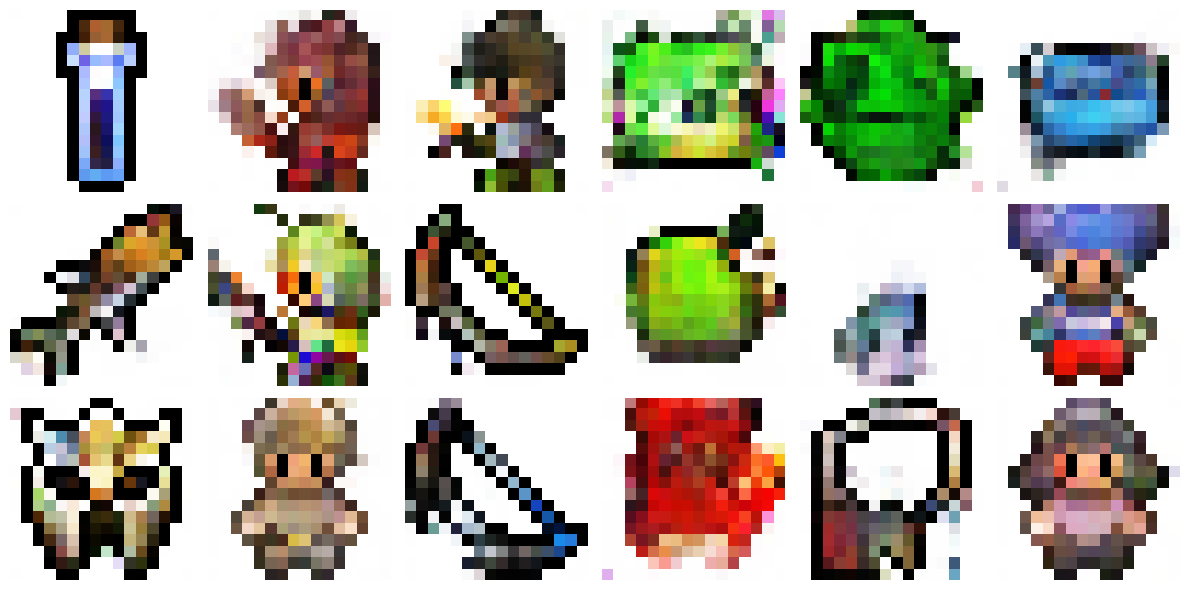

In [30]:
# load the best model and generate images
# model.load_weights(checkpoint_path)
model.plot_images()


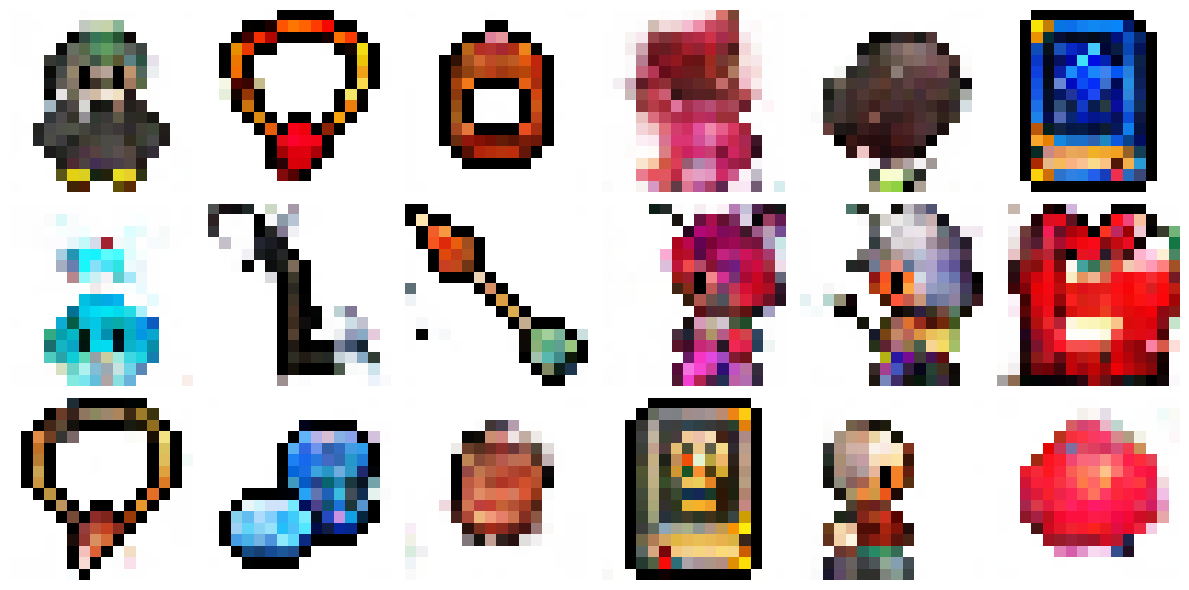

In [29]:
# load the best model and generate images
# model.load_weights(checkpoint_path)
model.plot_images()